# Day 10: Raster

Keeping it simple today and going to visualize some data from a familiar dataset, WorldPop

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration

In [1]:
import os
import rasterio as rio
import urllib.request
from rasterio.plot import plotting_extent
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import earthpy.plot as ep
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## WorldPop
Estimated population counts of a grid from [WorldPop](https://www.worldpop.org/project/categories?id=3). Multiple resolutions and versions are available. I will use the unconstrained UN-adjusted individiual country (resolution = 1km) datasets for this exercise.

In [2]:
# Choose country of interest (ISO3)
iso = "COL"

# Population estimate year
year = 2020

In [3]:
# Parse function with grid; FIXME: Support other resolutions from WP beyond 1km
def download_worldpop(iso, year=2020, res="1km"):
    ''' This function downloads a raster file of population estimates from
    WorldPop. At the moment, this will download the 2020 population estimate
    at a 1km resolution for the desired country. This can be later expanded to
    download the 100m dataset, or (where possible) a direct estimate of the
    number of buildings.'''

    # Arrange url; defeault  - 1km, UN adj
    url = f'ftp://ftp.worldpop.org.uk/GIS/Population/Global_2000_2020_1km_UNadj/{year}/{iso.upper()}/{iso.lower()}_ppp_2020_1km_Aggregated_UNadj.tif'
    if res == "100m":
        # If requested, use 100m, UN adj
        url = f'ftp://ftp.worldpop.org.uk/GIS/Population/Global_2000_2020/{year}/{iso.upper()}/{iso.lower()}_ppp_{year}_UNadj.tif'

    # Submit request
    r = urllib.request.urlopen(url)

    # Arrange desired name
    file_name = f"{iso.lower()}_ppp_{year}.tif"

    # Write to raster path
    f = open(file_name, 'wb')
    f.write(r.read())
    f.close()

    return file_name

# Download worldpop data
file_name = download_worldpop(iso, year)
print(f"Downloaded to {file_name}")

Downloaded to col_ppp_2020.tif


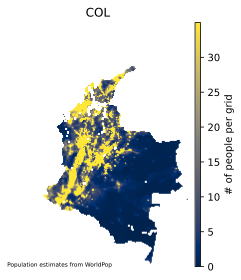

In [4]:
# Read raster data
extents, arr = None, None
with rio.open(file_name) as src:
    extents = plotting_extent(src)
    arr = src.read().squeeze()

# Remove bad balues
arr[(arr<0).astype(bool)] = np.nan

# Get threshold value
p = 90
thresh = np.nanpercentile(arr, p)

# Construct figure
fig, ax = plt.subplots(figsize=(7,4.5))
# Plot data
im = ax.imshow(arr, vmax=thresh, cmap="cividis")
# Set title
ax.set_title(iso.upper())
# Legend handling
cbar = ep.colorbar(im)
cbar.set_label("# of people per grid")
# Axis handling
ax.axis('off')
# Attribution
ax.annotate("Population estimates from WorldPop", xy=(0,0), xycoords='axes fraction',
            fontsize="xx-small", path_effects=[PathEffects.withStroke(linewidth=1.5, foreground="w")])

# Save result
out_file = f"10_{iso.upper()}.png"
out_path = os.path.join("..", "contributions", out_file)
fig.savefig(out_path, facecolor="w", dpi=300, bbox_inches="tight")

# Show result
plt.show()